# Enhancement

## 1. Retrieve Data from MongoDB
Retreive all documents from MongoDB and convrt it to a `pandas.DataFrame`

In [3]:
import pymongo

client = pymongo.MongoClient()

In [4]:
import pandas as pd
db = client.get_database("covid-us")
collection = db.get_collection("covid-us")
data = list(collection.find())
df = pd.DataFrame.from_records(data)  
df.drop('_id', axis=1, inplace=True)
# print(df.head())
# print(df.info())
df

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
...,...,...,...
315,2020-12-01,13799415,270633
316,2020-12-02,13999749,273518
317,2020-12-03,14217106,276375
318,2020-12-04,14446183,279012


In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


In [6]:
def determine_d(y, thresh):
    X = np.linspace(0,len(y)-1,len(y))
    X = X.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    if np.sqrt(reg.score(X,y)) < thresh:
        return 1
    else:
        return 2

In [7]:
def determine_p(y, thresh):
    y_len = len(y)
    y_mean = np.mean(y)
    y_var = np.var(y)
    p = 0
    y2 = y[y_len-1]
    y2_var = y2/y_var
    while True:
        y1 = y[y_len-1-p]
        pacf = y1*y2_var
        if  pacf > thresh:
            p += 1
        if p >= 5:
            break
    return min(max(1,p-1),5)

In [8]:
def determine_q(y, thresh):
    y_len = len(y)
    autocorr_list = np.correlate(y[y_len-10:y_len-1], y[y_len-10:y_len-1], mode='full')
    autocorr_len = len(autocorr_list)
    if autocorr_len % 2 == 1:
        sect = int(round((autocorr_len+1)/2))
    else:
        sect = int(round(autocorr_len/2))
    autocorr_list = autocorr_list[autocorr_len-sect:autocorr_len]
    q = 0
    while True:
        if autocorr_list[q] > thresh:
            q += 1
        if q >= 5:
            break
    return q

In [9]:
def predict(y,start,end):
    model=sm.tsa.statespace.SARIMAX(y,order=(determine_p(y, 1e-6), determine_d(y,30), determine_q(y, 100000)), dynamic = True)
    results=model.fit()
    df_forecast=results.predict(start=start, end=end, dynamic = True)
    return results, df_forecast

/home/hughes/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


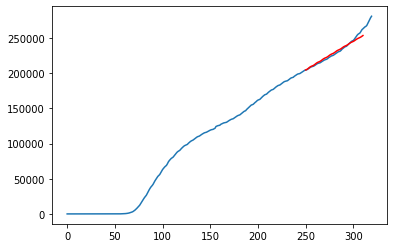

In [10]:
X = df.loc[:, df.columns != 'deaths']
y = df['deaths'].values
ordinal_ftrs = ['dates']
ordinal_cats = [list(X['date'])]
num_ftrs = ['cases']
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])
total_size = len(y)
train_ind = int(round(total_size*0.5))
val_ind = int(round(total_size*0.1))+train_ind
test1_ind = int(round(total_size*0.32))+val_ind
y_trunc1 = y[0:250]
y_trunc2 = y[250:-1]
# model=sm.tsa.statespace.SARIMAX(y,order=(1, 1, 1),seasonal_order=(1,1,1,12))
# model = sm.tsa.VARMAX(y, order=(1,1,1))
# model=sm.tsa.statespace.SARIMAX(y_trunc1,order=(3, 1, 1))
# results=model.fit()
# df_forecast=results.predict(start=250,end=310,dynamic=True)
results, df_forecast = predict(y_trunc1,250,310)
plt.plot(y)
plt.plot(range(250,311),df_forecast,color = 'r')
# plt.plot(range(248,301),results.predict(start=248,end=300,dynamic=True),color = 'r')